# Prepare raw data for training

Data preparation process includes: 

0. (Before conversion) Place raw data in `data/raw`

1. Copy raw data to `data/interim` and split data into training, testing, and validation sets

2. Downsize data to (256x256) and save to data/procesed

## Step 0: Place raw data in `data/raw`

The raw image data from Zahra consists of identically named '.tif' files of the OCT scans and the labeled ground truth masks. This image data was organized in the following:
```
   └── raw
      └── OCT_scans
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```

## Step 1.1: Copy data to `data/interim`

Raw data should never be modified. Hence it is copied into `data/interim`. This is the data that will be modified.

In [1]:
# Define raw data directory and interim directory
raw_dir = "../data/raw/OCT_scans_dataset3"
interim_dir = "../data/interim/OCT_scans_dataset3"

In [2]:
import shutil
copy_if_dir_exists = True
# Copy directory to interim dir
shutil.copytree(src=raw_dir, dst=interim_dir, dirs_exist_ok=copy_if_dir_exists)

'../data/interim/OCT_scans_dataset3'

Validate the images and masks are expected. Images should be an 8-bit image and masks should be binary labeled as 0 (background) and 1 (foreground)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import tifffile
import numpy as np
import os
# Get all image names
img_dir = f"{interim_dir}/images"
mask_dir = f"{interim_dir}/masks"
img_names = os.listdir(img_dir)
# Randomly select a single image name
img_name = np.random.choice(img_names)
print(f"NAME:\t{img_name}")

NAME:	U7125.tif


IMAGE STATS:
shape:	(512, 512)
dtype:	uint16
min:	0
max:	65533


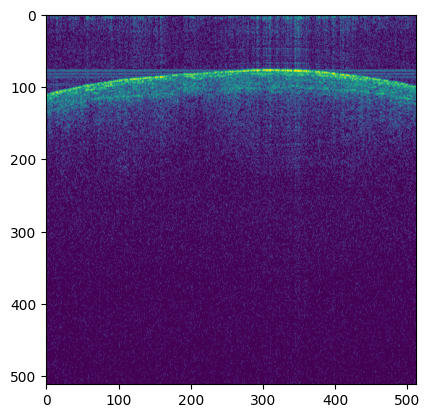

In [4]:
# Show image statistics and image
img_path = f"{img_dir}/{img_name}"
img = tifffile.imread(img_path)
print(f"IMAGE STATS:\nshape:\t{img.shape}\ndtype:\t{img.dtype}\nmin:\t{np.amin(img)}\nmax:\t{np.amax(img)}")
plt.imshow(img)

MASK STATS:
shape:	(512, 512)
dtype:	uint8
min:	0
max:	255
unique:	[  0 255]


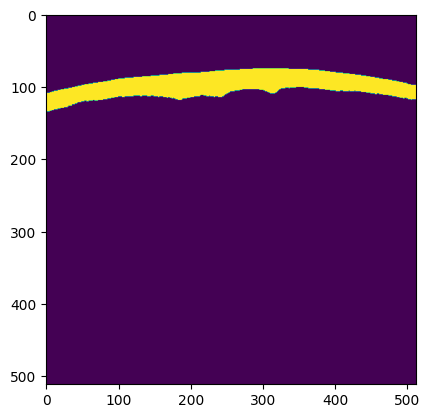

In [5]:
# Show mask statistics and image
mask_path = f"{mask_dir}/{img_name}"
mask = tifffile.imread(mask_path)
print(f"MASK STATS:\nshape:\t{mask.shape}\ndtype:\t{mask.dtype}\nmin:\t{np.amin(mask)}\nmax:\t{np.amax(mask)}\nunique:\t{np.unique(mask)}")
plt.imshow(mask)

## Step 1.2: Converting images to desired `dtype` and masks to categorically labeled `int` images.



In [6]:
def to_(img:np.ndarray, dtype, scaling:float,  offset:float = 0):
    """
    Return image converted to uint8
    
    Pixel-wise intensity formual: I = I*scaling + offset.
    Casts to dtype before return

    Args:
        img (np.ndarray): Image to convert
        dtype: dtype class to convert to
        scaling (float): Scaling in pixel-wise transform formula
        offset (float): Offset in pixel-wise transform formula
    """
    flt = img.astype(float)
    flt = flt*scaling + offset
    return flt.astype(dtype)


# Convert masks to 0-1 valued uint 8
scaling = 1/255
for mask_name in os.listdir(mask_dir):
    mask_path = f"{mask_dir}/{mask_name}"
    mask = tifffile.imread(mask_path)
    # Linearly downscale intensities to 8-bit and save image
    print(f"Converting {mask_name} mask")
    mask = to_(mask, np.uint8, scaling)
    tifffile.imwrite(mask_path, mask)

Converting U005.tif mask
Converting U016.tif mask
Converting U035.tif mask
Converting U059.tif mask
Converting U077.tif mask
Converting U079.tif mask
Converting U100.tif mask
Converting U10001.tif mask
Converting U10005.tif mask
Converting U10043.tif mask
Converting U10082.tif mask
Converting U10118.tif mask
Converting U1013.tif mask
Converting U10175.tif mask
Converting U10218.tif mask
Converting U1023.tif mask
Converting U10261.tif mask
Converting U10279.tif mask
Converting U10294.tif mask
Converting U10314.tif mask
Converting U10330.tif mask
Converting U10357.tif mask
Converting U1037.tif mask
Converting U10372.tif mask
Converting U1058.tif mask
Converting U1069.tif mask
Converting U1078.tif mask
Converting U1093.tif mask
Converting U11001.tif mask
Converting U11011.tif mask
Converting U11023.tif mask
Converting U11027.tif mask
Converting U11039.tif mask
Converting U11043.tif mask
Converting U11057.tif mask
Converting U11063.tif mask
Converting U11072.tif mask
Converting U11082.tif 

Re-validate the images are as expected format.

NAME:	U035.tif
IMAGE STATS:
shape:	(512, 512)
dtype:	uint16
min:	0
max:	63099


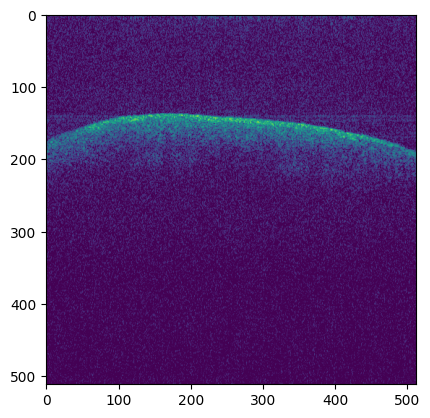

In [7]:
img_names = os.listdir(img_dir)
# Randomly select a single image name
img_name = np.random.choice(img_names)
print(f"NAME:\t{img_name}")
# Show image statistics and image
img_path = f"{img_dir}/{img_name}"
img = tifffile.imread(img_path)
print(f"IMAGE STATS:\nshape:\t{img.shape}\ndtype:\t{img.dtype}\nmin:\t{np.amin(img)}\nmax:\t{np.amax(img)}")
plt.imshow(img)

MASK STATS:
shape:	(512, 512)
dtype:	uint8
min:	0
max:	1
unique:	[0 1]


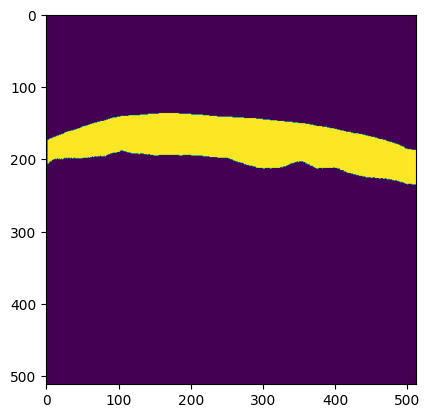

In [8]:
# Show mask statistics and image
mask_path = f"{mask_dir}/{img_name}"
mask = tifffile.imread(mask_path)
print(f"MASK STATS:\nshape:\t{mask.shape}\ndtype:\t{mask.dtype}\nmin:\t{np.amin(mask)}\nmax:\t{np.amax(mask)}\nunique:\t{np.unique(mask)}")
plt.imshow(mask)

## Step 1.3: Split data into training, testing, and validation sets

Following steps assume you have an data directory as shown:

```
   └── interim
      └── OCT_scans
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```

Where each "img" has the same filename between images<->masks.

After splitting, you will have the following data structure:
```
   └── interim
      └── OCT_scans
         ├── split
         │  ├── train
         │  │  ├── images
         │  │  └── masks
         │  ├── val
         │  │  ├── images
         │  │  └── masks
         │  └── test
         │     ├── images
         │     └── masks
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```


In [11]:
def single_dir_split(data_dir:str, img_dir_name:str, mask_dir_name:str, split_vals=(70, 20, 10), seed=1000, ext='.tif'):
    """
    Splits all images in `data_dir` according to `split_vals`. Output to "data_dir/split".
    
    Args:
        data_dir (str): Root dir containing image and mask directories
        img_dir_name (str): Name of 'images' dir in `data_dir`
        mask_dir_name (str): Name of 'masks' dir in `data_dir`
        split_vals (list): Split percentages as (train, val, test)
        seed (int): random seed
        ext (str): image extension
    """
    # Validate directory paths and split percentages
    img_dir = f"{data_dir}/{img_dir_name}"
    mask_dir = f"{data_dir}/{mask_dir_name}"
    if not os.path.isdir(img_dir):
        raise FileNotFoundError(f"Image directory not found: {img_dir}")
    if not os.path.isdir(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")
    if sum(split_vals) != 100:
        raise ValueError(f"Invalid split percentages: {split_vals}. Must add to 100")
    
    # Count number of images and masks
    imgs = os.listdir(img_dir)
    masks =os.listdir(mask_dir)
    if len(imgs) == 0:
        raise ValueError(f"No images in the image directory: {img_dir}")
    if len(masks) == 0:
        raise ValueError(f"No masks in the mask directory: {mask_dir}")
    
    
    # Count number of identically named images/masks
    img_mask_pairs = []
    for img in imgs:
        if img in masks:
            img_mask_pairs.append(img)
    n_unique = len(img_mask_pairs)
    if n_unique == 0:
        raise ValueError("Could not find identical filenames between image dir"
                         f"({img_dir}) and mask dir {mask_dir}.")
    print(f"Found {n_unique} image-mask pairs from {len(imgs)} images and {len(masks)} masks")
    
    # Generate random index for each file corresponding to train/val/test
    indices = np.arange(n_unique)
    np.random.seed(seed)
    np.random.shuffle(indices)
    train_len = int(round(split_vals[0]/100 * n_unique))
    val_len = int(round(split_vals[1]/100 * n_unique))
    test_len = int(round(split_vals[2]/100 * n_unique))
    train_inds = indices[:train_len]
    val_inds = indices[train_len:train_len+val_len] # val draws from front of randmized images
    test_inds = indices[train_len+val_len:] # test draws from back of randmized images

    # Create train/val/test directories
    train_dir = f"{data_dir}/split/train"
    val_dir = f"{data_dir}/split/val"
    test_dir = f"{data_dir}/split/test"
    train_exist = False
    val_exist = False
    test_exist = False 
    for dirname in [img_dir_name, mask_dir_name]:
        if not os.path.isdir(f"{train_dir}/{dirname}"):
            os.makedirs(f"{train_dir}/{dirname}")
        else:
            train_exist = True
        if not os.path.isdir(f"{val_dir}/{dirname}"):
            os.makedirs(f"{val_dir}/{dirname}")
        else:
            val_exist = True
        if not os.path.isdir(f"{test_dir}/{dirname}"):
            os.makedirs(f"{test_dir}/{dirname}")
        else:
            test_exist = True

    # Split data
    if not train_exist and not val_exist and not test_exist:
        print(f'copying data from {len(train_inds)} training instances')
        for train_index in train_inds:
            fname = img_mask_pairs[train_index]
            img_src = f"{img_dir}/{fname}"
            mask_src = f"{mask_dir}/{fname}"
            img_dst = f"{train_dir}/{img_dir_name}/{fname}"
            mask_dst = f"{train_dir}/{mask_dir_name}/{fname}"
            shutil.copy(img_src, img_dst)
            shutil.copy(mask_src, mask_dst)
        print(f'copying data from {len(val_inds)} validation instances')
        for val_index in val_inds:
            fname = img_mask_pairs[val_index]
            img_src = f"{img_dir}/{fname}"
            mask_src = f"{mask_dir}/{fname}"
            img_dst = f"{val_dir}/{img_dir_name}/{fname}"
            mask_dst = f"{val_dir}/{mask_dir_name}/{fname}"
            shutil.copy(img_src, img_dst)
            shutil.copy(mask_src, mask_dst)
        print(f'copying data from {len(test_inds)} testing instances')
        for test_index in test_inds:
            fname = img_mask_pairs[test_index]
            img_src = f"{img_dir}/{fname}"
            mask_src = f"{mask_dir}/{fname}"
            img_dst = f"{test_dir}/{img_dir_name}/{fname}"
            mask_dst = f"{test_dir}/{mask_dir_name}/{fname}"
            shutil.copy(img_src, img_dst)
            shutil.copy(mask_src, mask_dst)
    else:
        print("No data split because test/train/val already exsited.")

In [12]:
single_dir_split(data_dir=interim_dir, img_dir_name='images', mask_dir_name='masks', split_vals=(85, 15, 0), ext='.tif')

Found 298 image-mask pairs from 298 images and 298 masks
copying data from 253 training instances
copying data from 45 validation instances
copying data from 0 testing instances


## Step 1.4: Crop images and resize

Finally, take each image and crop it to a smaller size, resize it even smaller, and then save it. We downsize it drastically to reduce deep learning model overhead.

In [14]:
SIZE = 512
input_dir = f"{interim_dir}/split"
data_basename = os.path.basename(interim_dir)
output_dir = f"../data/processed/{data_basename}_{SIZE}x{SIZE}"
shutil.copytree(input_dir, output_dir)

'../data/processed/OCT_scans_dataset3_512x512'